# RNA-FM Tutorial

## Install RNA-FM

In [ ]:
!pip install rna-fm
!pip install -U numpy
!pip install biopython

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.6/46.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dep

If pip install fails to install the required packages, we can also uncomment the following cell to install it from source.

In [ ]:
# !git clone https://github.com/ml4bio/RNA-FM.git

# !pwd
# !ls
# %cd /content/RNA-FM
# !python setup.py install

In [ ]:
import fm  # for development with RNA-FM

from pathlib import Path
import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import math

from Bio import SeqIO  # for file parsing

from sklearn.manifold import TSNE  # for dimension reduction

from sklearn.model_selection import train_test_split  # for splitting train/val/test

from tqdm.notebook import tqdm  # for showing progress

import matplotlib.pyplot as plt

In [ ]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(f'using {device} device')

data_dir = '/content'  # for Colab
# data_dir = '../input/rnafm-tutorial/'

using cuda device


## Task 1. RNA Family Clustering

### Load data

In [ ]:
# load fasta data
fasta_paths = glob.glob(Path(data_dir, 'RF*.fasta'))
fasta_paths.sort()
print(len(fasta_paths))

3


In [ ]:
rfam_list = []  # list of RNA families

seqs = []  # list of two-element tuples [(sequence ID, sequence),]
labels = []  # list of labels correspond to each entry in the seqs list, the labels are the RNA families

for fasta_path in fasta_paths:
    rfam = Path(fasta_path).stem
    rfam_list.append(rfam)
    print(rfam)

    records = list(SeqIO.parse(fasta_path, 'fasta'))

    fasta_seqs = [str(record.seq) for record in records]
    fasta_seq_names = [record.id for record in records]

    seqs += [(seq_name, seq) for seq_name, seq in zip(fasta_seq_names, fasta_seqs)]

    labels += [rfam] * len(fasta_seq_names)

    print(len(seqs), len(labels))

RF00001
712 712
RF00005
1666 1666
RF00010
2124 2124


In [ ]:
# examine the data
print(seqs[:2])

[('X01556.1/3-118', 'CUUGACGAUCAUAGAGCGUUGGAACCACCUGAUCCCUUCCCGAACUCAGAAGUGAAACGACGCAUCGCCGAUGGUAGUGUGGGGUUUCCCCAUGUGAGAGUAGGUCAUCGUCAAGC'), ('X55260.1/3-119', 'UACGGCGGCCAUAGCGAAGGGGAAAUACCCGGUCCCAUCCCGAACCCGGAAGUCAAGCCCUUCAGCGCCGAUGGUACUGCAACCGAGAGGCUGUGGGAGAGUAGGACGCCGCCGGAC')]


### Load the pretrained model

In [ ]:
!gdown 1zflX5hHTxuwqcZm6A1npq7ubP8m7LdNX  # for Colab

In [ ]:
# Load RNA-FM model
fm_model, alphabet = fm.pretrained.rna_fm_t12(Path(data_dir, 'RNA-FM_pretrained.pth'))
batch_converter = alphabet.get_batch_converter()

fm_model.to(device)  # use GPU if available

fm_model.eval()  # disables dropout for deterministic results

BioBertModel(
  (embed_tokens): Embedding(25, 640, padding_idx=1)
  (layers): ModuleList(
    (0-11): 12 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=640, out_features=640, bias=True)
        (v_proj): Linear(in_features=640, out_features=640, bias=True)
        (q_proj): Linear(in_features=640, out_features=640, bias=True)
        (out_proj): Linear(in_features=640, out_features=640, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=640, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=640, bias=True)
      (final_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=240, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (embed_positions): LearnedPositionalEmbedding(1026, 640, padding_idx=1)
  (emb_layer_norm_

### Retrieve RNA-FM embeddings

In [ ]:
chunk_size = 20

# pre-allocate the space to save memory
token_embeddings = np.zeros((len(labels), 1024, 640))

# divide all the sequences into chunks for processing due to the GPU memory limit
for i in tqdm(range(0, len(seqs), chunk_size)):
    data = seqs[i:i+chunk_size]

    batch_labels, batch_strs, batch_tokens = batch_converter(data)

    # use GPU
    with torch.no_grad():
        results = fm_model(batch_tokens.to(device), repr_layers=[12])

    emb = results['representations'][12].cpu().numpy()

    token_embeddings[i:i+chunk_size, :emb.shape[1], :] = emb


print(token_embeddings.shape)

  0%|          | 0/107 [00:00<?, ?it/s]

(2124, 1024, 640)


### Dimension reduction

In [ ]:
token_embeddings = np.mean(token_embeddings, axis=1)

print(token_embeddings.shape)

(2124, 640)


In [ ]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)  # n_components is the dimension of the reduced data

embeddings = tsne.fit_transform(token_embeddings)

print(embeddings.shape)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d0244a077f0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/opt/conda/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error


(2124, 2)


### Visualization

['RF00001', 'RF00005', 'RF00010']
0
1
2


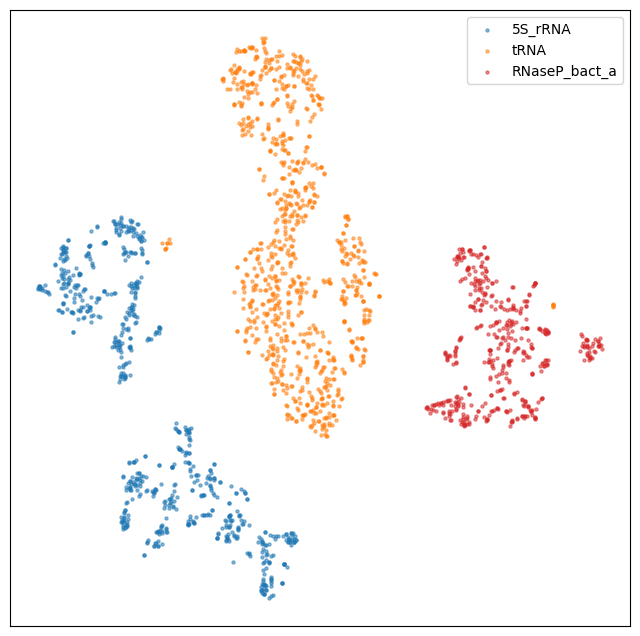

In [ ]:
colors = ['tab:blue', 'tab:orange', 'tab:red']
rfam_dict = {'RF00001': '5S_rRNA', 'RF00005': 'tRNA', 'RF00010': 'RNaseP_bact_a'}  # map the Rfam index to name

plt.figure(figsize=(8, 8))

print(sorted(list(set(labels))))

for i, label in enumerate(sorted(list(set(labels)))):
    # find the data points corresponding to the current label
    print(i)
    indices = [j for j, l in enumerate(labels) if l == label]
    plt.scatter(embeddings[indices, 0], embeddings[indices, 1], color=colors[i], s=5, alpha=0.5, label=rfam_dict[label])


plt.legend()
plt.xticks([])
plt.yticks([])

plt.show()

## Task 2. RNA Type Classification

### Load data

In [ ]:
fasta_path = Path(data_dir, 'format_rnacentral_active.100.sample-Max50.fasta')

records = list(SeqIO.parse(fasta_path, 'fasta'))

fasta_seqs = [str(record.seq) for record in records]
fasta_seq_names = [record.id for record in records]

print(len(fasta_seqs), len(fasta_seq_names))

labels = [record.description.split()[1] for record in records]

seqs = [(seq_name, seq) for seq_name, seq in zip(fasta_seq_names, fasta_seqs)]

num_class = len(set(labels))

print(len(seqs), len(labels))
print(f'number of classes: {len(set(labels))}')

label_to_num = {'miRNA': 0, 'snRNA': 1, 'other': 2, 'hammerhead_ribozyme': 3,
                'telomerase_RNA': 4, 'antisense_RNA': 5, 'precursor_RNA': 6,
                'tRNA': 7, 'snoRNA': 8, 'RNase_P_RNA': 9, 'pre_miRNA': 10,
                'misc_RNA': 11, 'rRNA': 12, 'siRNA': 13, 'vault_RNA': 14,
                'autocatalytically_spliced_intron': 15, 'guide_RNA': 16,
                'Y_RNA': 17, 'scRNA': 18, 'sRNA': 19, 'scaRNA': 20,
                'RNase_MRP_RNA': 21, 'tmRNA': 22, 'lncRNA': 23, 'ncRNA': 24,
                'piRNA': 25, 'ribozyme': 26, 'SRP_RNA': 27}

labels = [label_to_num[label] for label in labels]

1400 1400
1400 1400
number of classes: 28


### Retrieve RNA-FM embeddings

You don't need to download it again if you have already done so for the previous task.

In [ ]:
# !gdown 1zflX5hHTxuwqcZm6A1npq7ubP8m7LdNX  # for Colab

/bin/bash: gdown: command not found


In [ ]:
# Load RNA-FM model
fm_model, alphabet = fm.pretrained.rna_fm_t12(Path(data_dir, 'RNA-FM_pretrained.pth'))
batch_converter = alphabet.get_batch_converter()

fm_model.to(device)

fm_model.eval()  # disables dropout for deterministic results

BioBertModel(
  (embed_tokens): Embedding(25, 640, padding_idx=1)
  (layers): ModuleList(
    (0-11): 12 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=640, out_features=640, bias=True)
        (v_proj): Linear(in_features=640, out_features=640, bias=True)
        (q_proj): Linear(in_features=640, out_features=640, bias=True)
        (out_proj): Linear(in_features=640, out_features=640, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=640, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=640, bias=True)
      (final_layer_norm): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=240, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (embed_positions): LearnedPositionalEmbedding(1026, 640, padding_idx=1)
  (emb_layer_norm_

In [ ]:
chunk_size = 50

# pre-allocate the space to save memory
token_embeddings = np.zeros((len(labels), 1024, 640))

# divide all the sequences into chunks for processing due to the GPU memory limit
for i in tqdm(range(0, len(seqs), chunk_size)):
    data = seqs[i:i+chunk_size]

    # print(f'{i}-{i+chunk_size}/{len(seqs)}')

    batch_labels, batch_strs, batch_tokens = batch_converter(data)

    # use GPU
    with torch.no_grad():
        results = fm_model(batch_tokens.to(device), repr_layers=[12])

    emb = results["representations"][12].cpu().numpy()

    token_embeddings[i:i+chunk_size, :emb.shape[1], :] = emb


print(token_embeddings.shape)

  0%|          | 0/28 [00:00<?, ?it/s]

(1400, 1024, 640)


### Construct the dataset and classifier

In [ ]:
class RNATypeDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # use the mean of the RNA-FM embedding along the sequence dimension
        # so that all the embeddings are converted from (L, 640) -> (640,)
        return np.mean(self.embeddings[idx], axis=0), self.labels[idx]

In [ ]:
class RNATypeClassifier(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.fc = nn.Linear(640, num_class)

    def forward(self, x):
        x = self.fc(x)

        return x

In [ ]:
# each class have 50 samples, use 30 for train, 10 for val, and 10 for test (achieved by using stratify)
x_train_val, x_test, y_train_val, y_test = train_test_split(token_embeddings, labels,
                                                            test_size=0.2, random_state=42, stratify=labels)

x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val,
                                                  test_size=0.2, random_state=42, stratify=y_train_val)

print(x_train.shape, x_val.shape, x_test.shape)

(896, 1024, 640) (224, 1024, 640) (280, 1024, 640)


In [ ]:
def class_distribution(labels):
    classes, counts = np.unique(labels, return_counts=True)
    distribution = counts / counts.sum()
    return dict(zip(classes, distribution))


train_dist = class_distribution(y_train)
val_dist = class_distribution(y_val)
test_dist = class_distribution(y_test)

print(train_dist)
print(val_dist)
print(test_dist)

{0: 0.03571428571428571, 1: 0.03571428571428571, 2: 0.03571428571428571, 3: 0.03571428571428571, 4: 0.03571428571428571, 5: 0.03571428571428571, 6: 0.03571428571428571, 7: 0.03571428571428571, 8: 0.03571428571428571, 9: 0.03571428571428571, 10: 0.03571428571428571, 11: 0.03571428571428571, 12: 0.03571428571428571, 13: 0.03571428571428571, 14: 0.03571428571428571, 15: 0.03571428571428571, 16: 0.03571428571428571, 17: 0.03571428571428571, 18: 0.03571428571428571, 19: 0.03571428571428571, 20: 0.03571428571428571, 21: 0.03571428571428571, 22: 0.03571428571428571, 23: 0.03571428571428571, 24: 0.03571428571428571, 25: 0.03571428571428571, 26: 0.03571428571428571, 27: 0.03571428571428571}
{0: 0.03571428571428571, 1: 0.03571428571428571, 2: 0.03571428571428571, 3: 0.03571428571428571, 4: 0.03571428571428571, 5: 0.03571428571428571, 6: 0.03571428571428571, 7: 0.03571428571428571, 8: 0.03571428571428571, 9: 0.03571428571428571, 10: 0.03571428571428571, 11: 0.03571428571428571, 12: 0.035714285714

In [ ]:
# hyper-parameters

batch_size = 8
lr = 1e-3
epochs = 100

In [ ]:
train_dataset = RNATypeDataset(x_train, y_train)
val_dataset = RNATypeDataset(x_val, y_val)
test_dataset = RNATypeDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = RNATypeClassifier(num_class).to(device)
print(model)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

RNATypeClassifier(
  (fc1): Linear(in_features=640, out_features=28, bias=True)
  (relu): ReLU()
)


### Train the model

In [ ]:
max_val_acc = -1
best_epoch = -1

train_loss_history = []
val_loss_history = []

train_acc_history = []
val_acc_history = []

for epoch in tqdm(range(epochs)):

    # train the model
    train_losses = []
    train_preds = []
    train_targets = []

    model.train()

    for batch in train_loader:
        x, y = batch
        x, y = x.to(device).float(), y.to(device).long()

        # no need to apply the softmax function since it has been included in the loss function
        y_pred = model(x)

        # y_pred: (B, C) with class probabilities, y shape: (B,) with class indices
        loss = criterion(y_pred, y)

        train_losses.append(loss.item())
        train_preds.append(torch.max(y_pred.detach(),1)[1])
        train_targets.append(y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # validate the model
    val_losses = []
    val_preds = []
    val_targets = []

    model.eval()

    for batch in val_loader:
        x, y = batch
        x, y = x.to(device).float(), y.to(device).long()

        y_pred = model(x)

        # y_pred: (B, C) with class probabilities, y shape: (B,) with class indices
        loss = criterion(y_pred, y)

        val_losses.append(loss.item())
        val_preds.append(torch.max(y_pred.detach(),1)[1])
        val_targets.append(y)

    # calculate the accuracy
    train_preds = torch.cat(train_preds, dim=0)
    train_targets = torch.cat(train_targets, dim=0)
    train_acc = (train_preds == train_targets).float().mean().cpu()

    val_preds = torch.cat(val_preds, dim=0)
    val_targets = torch.cat(val_targets, dim=0)
    val_acc = (val_preds == val_targets).float().mean().cpu()

    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    # save the model checkpoint for the best validation accuracy
    if val_acc > max_val_acc:
        torch.save({'model_state_dict': model.state_dict()}, 'rna_type_checkpoint.pt')
        best_epoch = epoch
        max_val_acc = val_acc

    # show intermediate steps
    if epoch % 20 == 1:
        tqdm.write(f'epoch {epoch}/{epochs}: train loss={np.mean(train_loss_history):.6f}, '
                   f'train acc={train_acc:.6f}, '
                   f'val loss={np.mean(val_loss_history):.6f}, '
                   f'val acc={val_acc:.6f}')

    train_loss_history.append(np.mean(train_losses))
    val_loss_history.append(np.mean(val_losses))

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 1/100: train loss=3.050085, train acc=0.311384, val loss=2.801211, val acc=0.375000
epoch 21/100: train loss=1.743817, train acc=0.810268, val loss=1.736742, val acc=0.750000
epoch 41/100: train loss=1.333420, train acc=0.876116, val loss=1.418566, val acc=0.781250
epoch 61/100: train loss=1.101786, train acc=0.896205, val loss=1.249271, val acc=0.812500
epoch 81/100: train loss=0.947265, train acc=0.919643, val loss=1.143016, val acc=0.821429


### Visualize training results

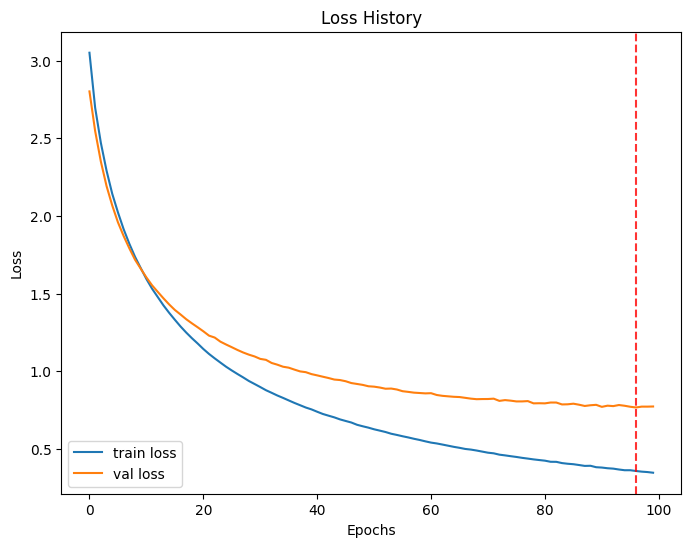

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(train_loss_history, label='train loss')
plt.plot(val_loss_history, label='val loss')

# the epoch with best validation loss
plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.8)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss History')

plt.legend()

plt.show()

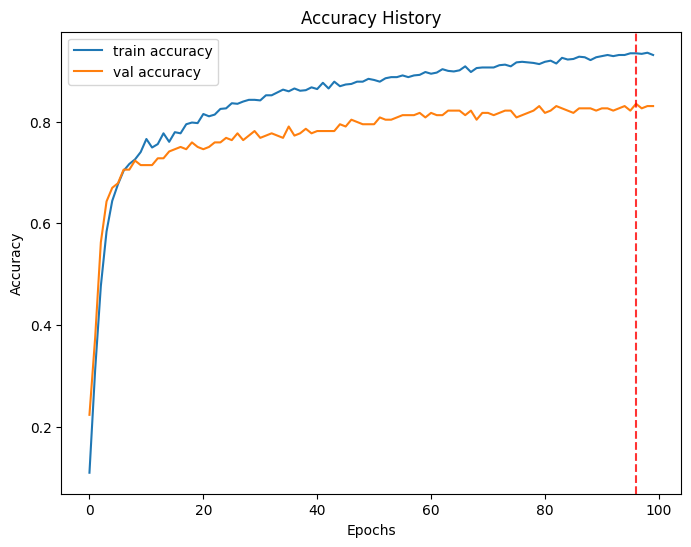

In [ ]:
plt.figure(figsize=(8, 6))

plt.plot(train_acc_history, label='train accuracy')
plt.plot(val_acc_history, label='val accuracy')

# the epoch with best validation accuracy
plt.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.8)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy History')

plt.legend()

plt.show()

### Test the model

In [ ]:
# test the model
test_preds = []

model.load_state_dict(torch.load('rna_type_checkpoint.pt')['model_state_dict'])

model.eval()

for batch in test_loader:
    x, y = batch
    x, y = x.to(device).float(), y.to(device).long()

    output = model(x)

    _, y_pred = torch.max(output.data, 1)  # argmax in y_pred
    # print(y_pred.shape)

    test_preds.append(y_pred.cpu().numpy())


test_preds = np.concatenate(test_preds)

total = len(y_test)
correct = np.sum(test_preds == y_test)

print(f'total number of test data: {total}, correct={correct}, test acc={correct/total:.4f}')

total number of test data: 280, correct=219, test acc=0.7821
